In [53]:
import torch
from tqdm import tqdm
from torchvision import datasets, transforms
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import nbformat
import os
import collections
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

checkpoint_path = 'weights/checkpoint.pth'

PRINT_IMG = True
AUGMENT_DATASET = False
TRANSFORM_DATASET = False

OPTIMIZER='SGD'

### Hyperparameters ###
BATCH_SIZE = 128
LEARNING_RATE = 0.0025
MOMENTUM = 0.9
EPOCHS = 20

WEIGHT_DECAY = 0

### Early Stopping ###
EARLY_STOPPING = True
ES_PATIENCE = 5

SEED = 0

random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

In [ ]:
def create_image_pairs(dataset):
    image_pairs = []
    labels = []

    max_size_class = len(dataset) // 3  # Limita il numero massimo di campioni per ciascuna classe
    count_class_0 = 0  # Contatore per la classe A > B
    count_class_1 = 0  # Contatore per la classe A < B
    count_class_2 = 0  # Contatore per la classe A = B
    i = 0
    
    # Continua finché tutte le classi non sono bilanciate
    while count_class_0 < max_size_class or count_class_1 < max_size_class or count_class_2 < max_size_class:
        img_A, label_A = dataset[i]

        class_busy = True
        while class_busy:  # Cerca una relazione valida che non sia satura
            idx_B = random.randint(0, len(dataset) - 1)
            img_B, label_B = dataset[idx_B]

            # Determina la relazione tra le etichette
            if label_A > label_B:
                relation_label = 0  # A > B
            elif label_A < label_B:
                relation_label = 1  # A < B
            else:
                relation_label = 2  # A = B

            # Verifica se la classe ha già raggiunto il limite massimo
            if relation_label == 0 and count_class_0 < max_size_class:
                count_class_0 += 1
                class_busy = False
            elif relation_label == 1 and count_class_1 < max_size_class:
                count_class_1 += 1
                class_busy = False
            elif relation_label == 2 and count_class_2 < max_size_class:
                count_class_2 += 1
                class_busy = False

        # Aggiungi la coppia solo se la classe non ha raggiunto il limite massimo
        image_pairs.append((img_A, img_B))
        labels.append(relation_label)
        i += 1

    return image_pairs, labels


In [3]:
# Dataset personalizzato per gestire le coppie di immagini
class MNISTPairDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.image_pairs, self.labels = create_image_pairs(dataset)

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        img_A, img_B = self.image_pairs[idx]
        label = self.labels[idx]

        # Concatenare le immagini lungo il canale (depth)
        concatenated_image = torch.cat((img_A, img_B), dim=0)

        return concatenated_image, label


In [4]:
# Funzione per visualizzare una coppia di immagini e la loro etichetta di relazione
def show_image_pair(img_A, img_B, relation_label):
    relation_labels = {0: 'A > B', 1: 'A < B', 2: 'A = B'}

    # Converte il tensore in numpy array per visualizzazione
    img_A = img_A.squeeze().numpy()  # Rimuove la dimensione del canale
    img_B = img_B.squeeze().numpy()

    # Crea una figura con due immagini, riducendo la dimensione per occupare meno spazio
    fig, axes = plt.subplots(1, 2, figsize=(4, 4))  # Dimensioni ridotte

    # Mostra le immagini
    axes[0].imshow(img_A, cmap='gray')
    axes[0].set_title('Image A')
    axes[0].axis('off')  # Rimuove gli assi

    axes[1].imshow(img_B, cmap='gray')
    axes[1].set_title('Image B')
    axes[1].axis('off')  # Rimuove gli assi

    # Riduce lo spazio tra i subplots
    plt.tight_layout(pad=0.5)  # Riduce il padding tra le immagini

    # Mostra il titolo della relazione
    plt.suptitle(f'Relation: {relation_labels[relation_label]}', y=0.85)  # Posiziona il titolo più vicino
    plt.show()


In [5]:
# Funzione per visualizzare più coppie di immagini in un'unica figura
def show_dataset(dataset, num_images=5):
    dataiter = iter(dataset)
    images, labels = next(dataiter)

    # Mappa delle etichette di relazione
    relation_labels = {0: 'A > B', 1: 'A < B', 2: 'A = B'}

    # Numero di righe: ogni riga contiene 1 coppia di immagini (2 colonne)
    num_rows = num_images  # 1 coppia per riga

    # Crea una griglia di subplots: num_rows righe, 3 colonne (Image A, Relation, Image B)
    fig, axes = plt.subplots(num_rows, 3, figsize=(6, num_rows * 2))
    
    for i in range(num_images):
        concatenated_image = images[i]
        label = labels[i].item()

        img_A = concatenated_image[0, :, :]
        img_B = concatenated_image[1, :, :]

        # Mostra l'immagine A nel subplot
        axes[i, 0].imshow(img_A, cmap='gray')
        axes[i, 0].set_title('Image A')
        axes[i, 0].axis('off')

        # Mostra l'etichetta di relazione nel subplot centrale
        axes[i, 1].text(0.5, 0.5, f'Relation: {relation_labels[label]}', 
                        fontsize=12, ha='center', va='center')
        axes[i, 1].axis('off')

        # Mostra l'immagine B nel subplot
        axes[i, 2].imshow(img_B, cmap='gray')
        axes[i, 2].set_title('Image B')
        axes[i, 2].axis('off')  # Nascondi gli assi

    # Applica il layout compatto per ridurre lo spazio tra i subplot
    plt.tight_layout(pad=0.5)
    plt.show()
    return fig


In [6]:
def dataset_statistics(dataset):
    image_shapes = set()
    pair_relations_counts = collections.Counter()

    for img_pair, label in dataset:
        # Aggiorna la distribuzione delle classi
        pair_relations_counts[label] += 1

        # Controlla la dimensione delle immagini
        image_shapes.add(img_pair.shape)

    # Riassumi le informazioni
    total_samples = len(dataset)
    class_distribution = dict(pair_relations_counts)

    print(f"Numero totale di campioni: {total_samples}")
    print(f"Distribuzione delle relazioni (A > B, A < B, A = B): {class_distribution}")
    print(f"Dimensioni delle immagini trovate nel dataset: {image_shapes}")

    # Calcolo delle percentuali delle classi
    for relation, count in class_distribution.items():
        percentage = (count / total_samples) * 100
        print(f"Relazione {relation}: {count} campioni ({percentage:.2f}%)")
    
    print("\n")
    return class_distribution, image_shapes


In [7]:
def dataset_raw_statistics(dataset):
    class_counts = collections.Counter()
    percentage = {}

    for _, label in dataset:
        class_counts[label] += 1

    for label, count in class_counts.items():
        percentage[label] = (count / len(dataset)) * 100
    
    return class_counts, percentage

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_dataset_statistics(dataset, dataset_name="Dataset"):
    # Ottieni le statistiche con la funzione precedente
    class_distribution, image_shapes = dataset_statistics(dataset)
    
    # Imposta uno stile per i grafici
    sns.set(style="whitegrid")
    
    # 1. Istogramma della distribuzione delle classi (relazioni A > B, A < B, A = B)
    plt.figure(figsize=(10, 6))
    classes = ['A > B', 'A < B', 'A = B']
    counts = [class_distribution.get(0, 0), class_distribution.get(1, 0), class_distribution.get(2, 0)]
    
    sns.barplot(x=classes, y=counts, hue=classes, palette='viridis', dodge=False, legend=False)
    plt.title(f'Distribuzione delle Relazioni nel {dataset_name}', fontsize=16)
    plt.ylabel('Numero di campioni')
    plt.xlabel('Relazioni tra le immagini')
    plt.show()
    
    # 3. Box plot per esplorare la distribuzione delle classi in percentuale
    plt.figure(figsize=(10, 6))
    percentages = [(count / len(dataset)) * 100 for count in counts]
    sns.barplot(x=classes, y=percentages, hue=classes, palette='coolwarm', dodge=False, legend=False)
    plt.title(f'Percentuale di Relazioni nel {dataset_name}', fontsize=16)
    plt.ylabel('Percentuale (%)')
    plt.xlabel('Relazioni tra le immagini')
    plt.show()

In [9]:
def plot_dataset_raw_statistics(dataset, dataset_name="Dataset"):
    class_counts, percentage = dataset_raw_statistics(dataset)

    # Imposta uno stile per i grafici
    sns.set(style="whitegrid")

    plt.figure(figsize=(10, 6))
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    sns.barplot(x=classes, y=counts, hue=classes, palette='viridis', dodge=False, legend=False)
    plt.title(f'Distribuzione delle Classi nel {dataset_name}', fontsize=16)
    plt.ylabel('Numero di campioni')
    plt.xlabel('Classi')
    plt.show()

    plt.figure(figsize=(10, 6))
    percentages = list(percentage.values())
    sns.barplot(x=classes, y=percentages, hue=classes, palette='coolwarm', dodge=False, legend=False)
    plt.title(f'Percentuale delle Classi nel {dataset_name}', fontsize=16)
    plt.ylabel('Percentuale (%)')
    plt.xlabel('Classi')
    plt.show()    

In [10]:
# Definisci la funzione per aggiungere rumore gaussiano
def add_gaussian_noise(tensor, mean=0.0, std=0.05):
    return tensor + std * torch.randn_like(tensor) + mean

In [11]:
# Definisci la funzione per invertire i colori
def invert_colors(tensor):
    return 1 - tensor

In [12]:
def create_train_dataset(transform_dataset=False, augment_dataset=False):
    transform_norm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.1307,), (0.3081,))])

    transform_augmented = transforms.Compose([
        transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.8, 1.2)),
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.RandomChoice([
            transforms.Lambda(lambda x: add_gaussian_noise(x)),
            transforms.Lambda(lambda x: invert_colors(x)),
            transforms.Lambda(lambda x: x),
        ]),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST(root='./data', train=True, download=True,
                               transform=transform_norm)
    
    train_dataset_augmented = datasets.MNIST(root='./data', train=True, download=True,
                               transform=transform_augmented)

    train_pair_dataset = MNISTPairDataset(train_dataset)
    train_pair_dataset_augmented = MNISTPairDataset(train_dataset_augmented)

    print(f"Dimensione del dataset originale: {len(train_pair_dataset)}")
    print(f"Dimensione del dataset trasformato: {len(train_pair_dataset_augmented)}")

    if augment_dataset:
        train_pair_dataset = torch.utils.data.ConcatDataset([train_pair_dataset, train_pair_dataset_augmented])
        print(f"Dimensione del dataset combinato: {len(train_pair_dataset)}")
    
    if transform_dataset:
        train_pair_dataset = train_pair_dataset_augmented

    return train_pair_dataset, train_dataset


In [13]:
def create_test_dataset(validation_split=0.2):
    transform_norm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.1307,), (0.3081,))])
    
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_norm)

    test_pair_dataset = MNISTPairDataset(test_dataset)

    total_test_size = len(test_pair_dataset)
 
    validation_size = int(total_test_size * validation_split)
    test_size = total_test_size - validation_size

    test_subset, validation_subset = torch.utils.data.random_split(test_pair_dataset, [test_size, validation_size])
    return test_subset, validation_subset, test_dataset

In [14]:
def create_data_loader(train_dataset, validation_dataset, test_dataset, batch_size):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, validation_loader, test_loader

In [15]:
train_dataset, train_dataset_raw = create_train_dataset(TRANSFORM_DATASET, AUGMENT_DATASET)
test_dataset, validation_dataset, test_dataset_raw = create_test_dataset(validation_split=0.7)

/home/andrea/miniconda3/envs/pytorch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Dimensione del dataset originale: 60000
Dimensione del dataset trasformato: 60000


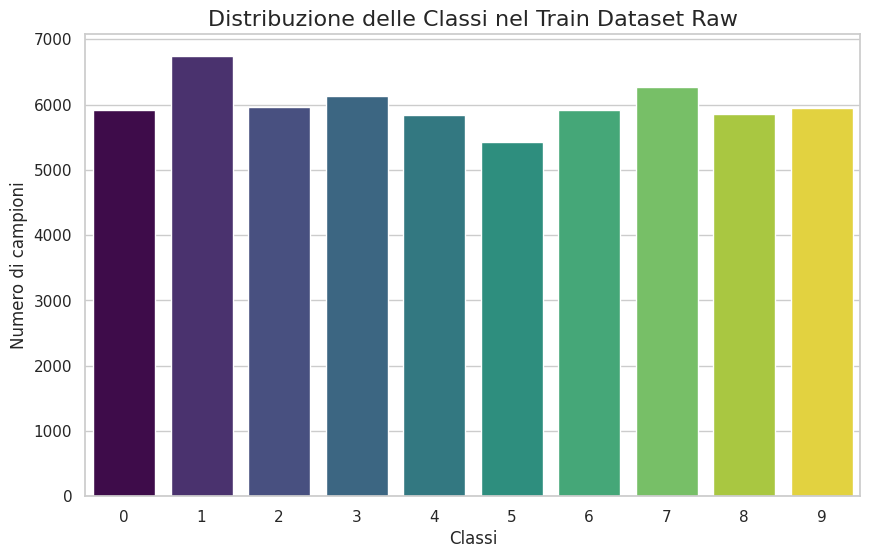

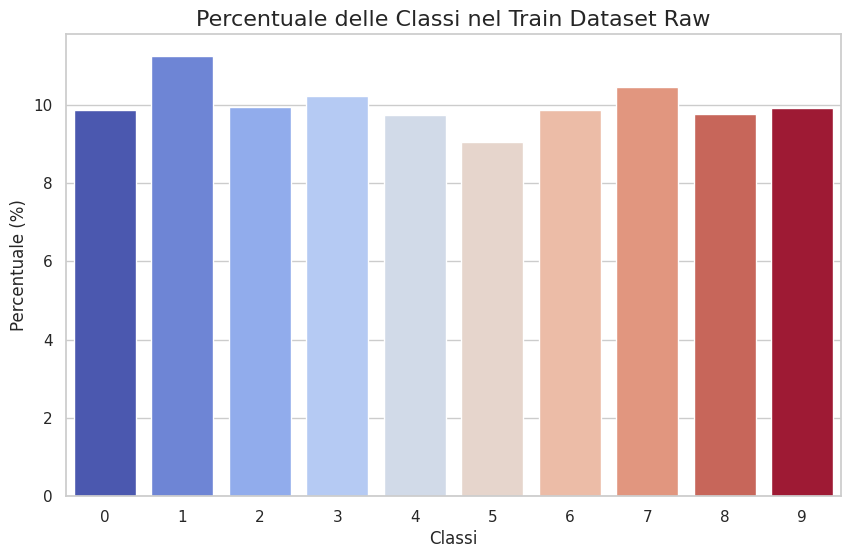

In [16]:
plot_dataset_raw_statistics(train_dataset_raw, "Train Dataset Raw")

Numero totale di campioni: 60000
Distribuzione delle relazioni (A > B, A < B, A = B): {0: 20000, 1: 20000, 2: 20000}
Dimensioni delle immagini trovate nel dataset: {torch.Size([2, 32, 32])}
Relazione 0: 20000 campioni (33.33%)
Relazione 1: 20000 campioni (33.33%)
Relazione 2: 20000 campioni (33.33%)




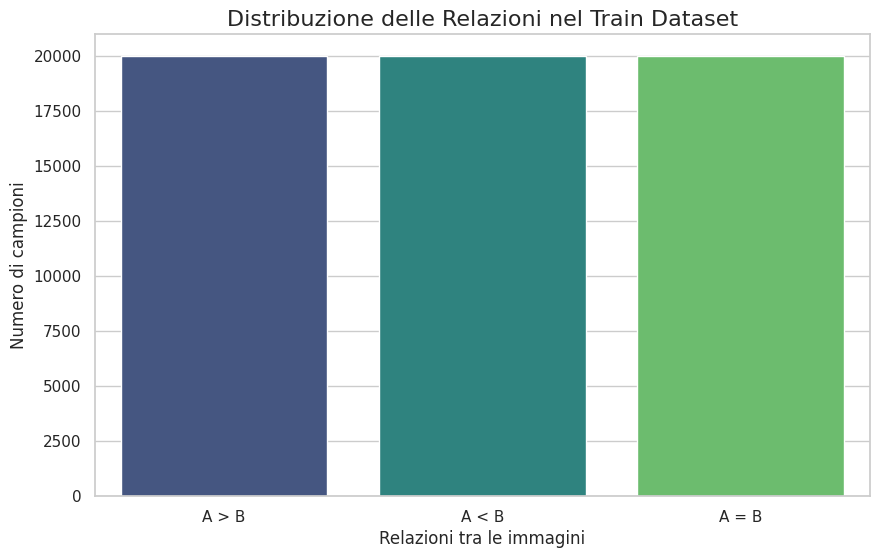

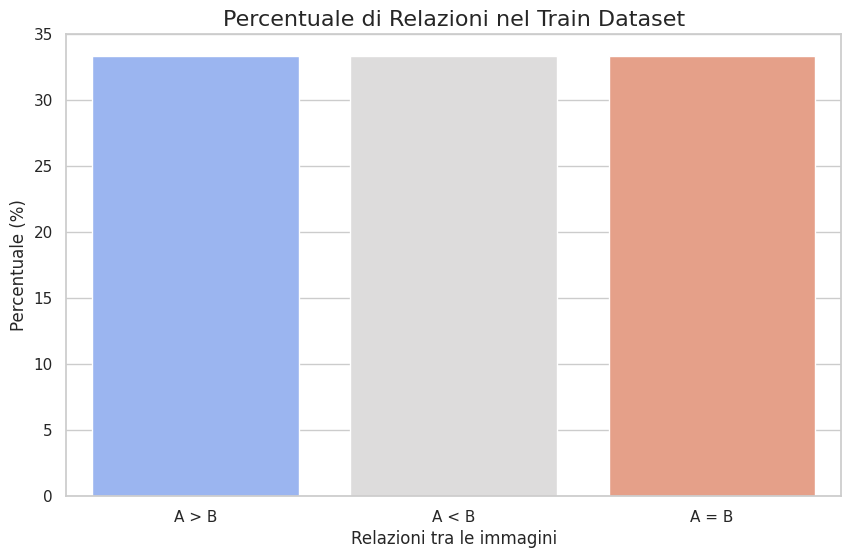

In [17]:
plot_dataset_statistics(train_dataset, dataset_name="Train Dataset")

Numero totale di campioni: 3000
Distribuzione delle relazioni (A > B, A < B, A = B): {1: 990, 2: 1021, 0: 989}
Dimensioni delle immagini trovate nel dataset: {torch.Size([2, 32, 32])}
Relazione 1: 990 campioni (33.00%)
Relazione 2: 1021 campioni (34.03%)
Relazione 0: 989 campioni (32.97%)




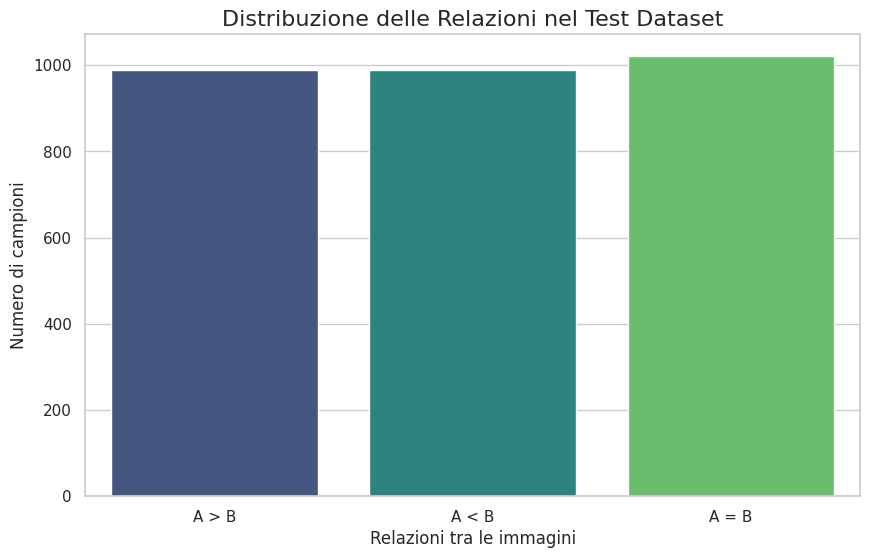

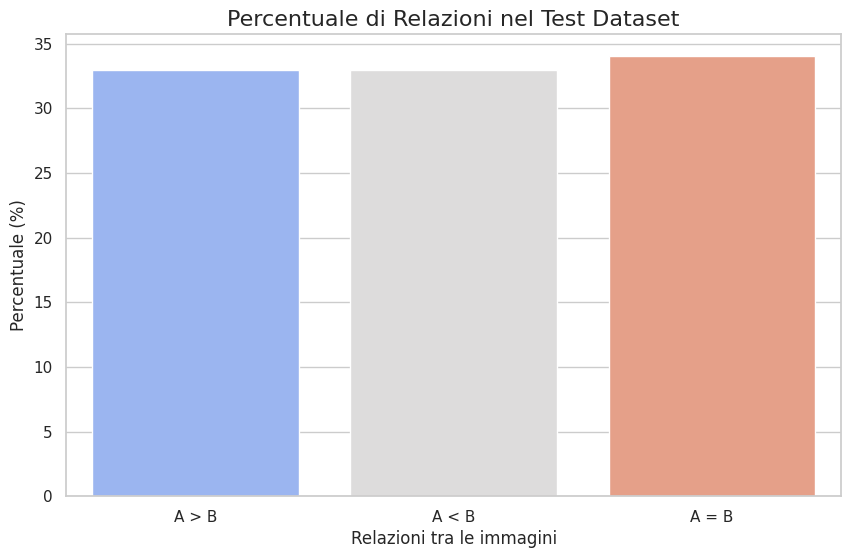

In [18]:
plot_dataset_statistics(test_dataset, dataset_name="Test Dataset")

Numero totale di campioni: 6999
Distribuzione delle relazioni (A > B, A < B, A = B): {0: 2344, 1: 2343, 2: 2312}
Dimensioni delle immagini trovate nel dataset: {torch.Size([2, 32, 32])}
Relazione 0: 2344 campioni (33.49%)
Relazione 1: 2343 campioni (33.48%)
Relazione 2: 2312 campioni (33.03%)




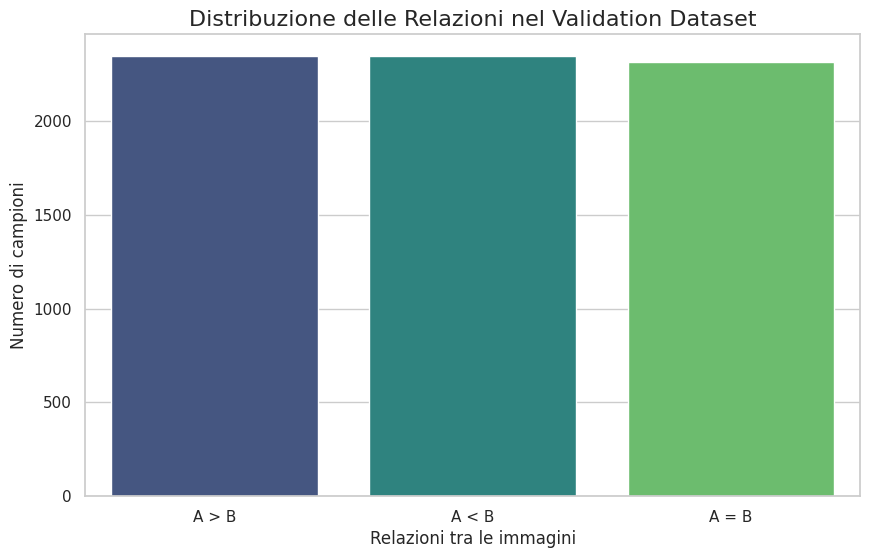

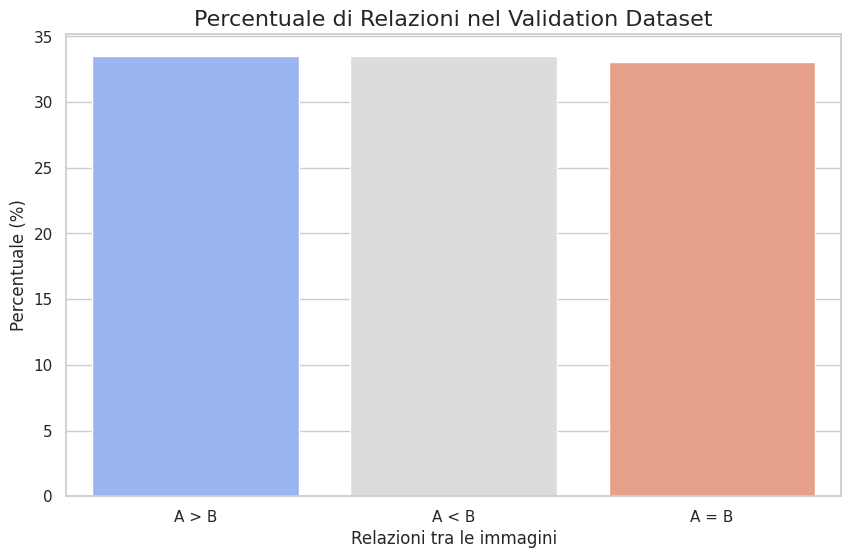

In [19]:
plot_dataset_statistics(validation_dataset, dataset_name="Validation Dataset")

In [20]:
train_loader, validation_loader, test_loader = create_data_loader(train_dataset, validation_dataset, test_dataset, BATCH_SIZE)

In [21]:
print("Size train_loader: ", len(train_loader), " Size train_dataset: ", len(train_dataset))
print("Size validation_loader: ", len(validation_loader), " Size validation_dataset: ", len(validation_dataset))
print("Size test_loader: ", len(test_loader), " Size test_dataset: ", len(test_dataset))

Size train_loader:  469  Size train_dataset:  60000
Size validation_loader:  55  Size validation_dataset:  6999
Size test_loader:  24  Size test_dataset:  3000


In [ ]:
# Funzione per salvare un checkpoint
def save_checkpoint(epoch, model, optimizer, scheduler, best_val_loss, patience_counter):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_val_loss': best_val_loss,
        'patience_counter': patience_counter
    }, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch+1}.")

In [ ]:
# Funzione per caricare un checkpoint
def load_checkpoint(model, optimizer, scheduler):
    if torch.cuda.is_available():
        checkpoint = torch.load(checkpoint_path)
    else:
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    print(f"Checkpoint loaded from epoch {checkpoint['epoch']+1}.")
    return checkpoint['epoch'], checkpoint['best_val_loss'], checkpoint['patience_counter']

In [38]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [39]:
class CustomLeNet5(nn.Module):
    def __init__(self):
        super(CustomLeNet5, self).__init__()
        self.conv1 = nn.Conv2d(2, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CustomLeNet5()
print(model)


CustomLeNet5(
  (conv1): Conv2d(2, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)


In [40]:
# Definisci la funzione di perdita e l'ottimizzatore
criterion = nn.CrossEntropyLoss()
if OPTIMIZER == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
elif OPTIMIZER == 'ADAM':
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

images dtype: torch.float32, labels dtype: torch.int64


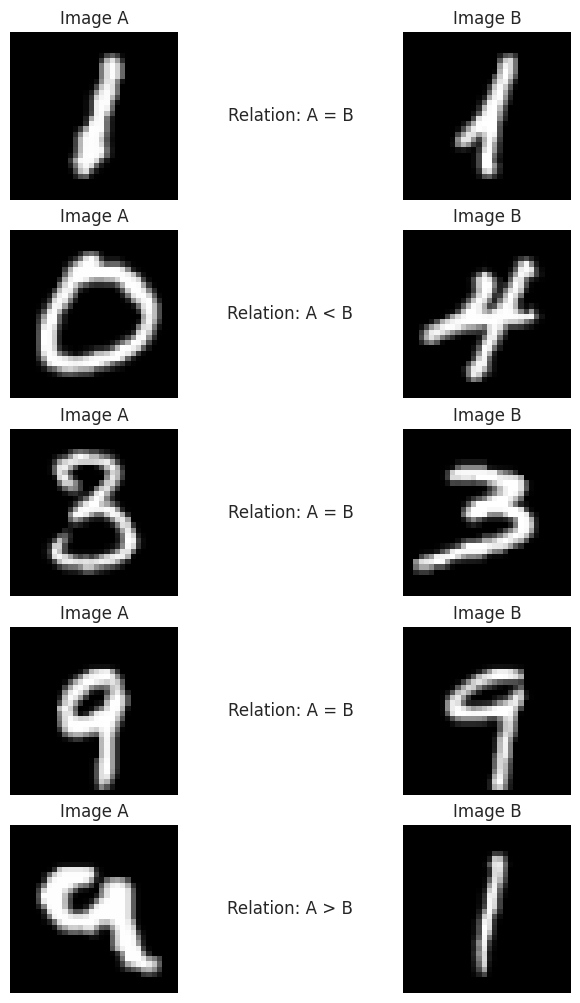

In [41]:

if OPTIMIZER == 'SGD':
    fileName = f"runs/log32x32_bs={BATCH_SIZE}_lr={LEARNING_RATE}_e={EPOCHS}_m={MOMENTUM}_aug={AUGMENT_DATASET}_tra={TRANSFORM_DATASET}_opt={OPTIMIZER}"
elif OPTIMIZER == 'ADAM':
    fileName = f"runs/log32x32_bs={BATCH_SIZE}_lr={LEARNING_RATE}_e={EPOCHS}_aug={AUGMENT_DATASET}_tra={TRANSFORM_DATASET}_opt={OPTIMIZER}"

writer = SummaryWriter(fileName)

# Ottieni un batch dal dataloader
batch = next(iter(train_loader))
images, labels = batch

# Stampa il tipo di dato di ciascun tensore per debug
print(f"images dtype: {images.dtype}, labels dtype: {labels.dtype}")

writer.add_graph(model, next(iter(train_loader))[0])

writer.add_figure('Image_pair', show_dataset(train_loader, 5))

In [ ]:
# Definisci le liste per salvare i valori di loss e accuracy

def train(train_data_loader, model):
    print('Training')
    train_itr = 0
    correct_train = 0
    total_train = 0
    running_loss = 0.0
    train_loss_list = []
    train_accuracy_list = []
    
    # Inizializzazione della progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        running_loss += loss_value

        train_loss_list.append(loss_value)
        train_accuracy_list.append(100 * correct_train / total_train)

        train_itr += 1
    
        # Aggiorna il valore della loss nella progress bar per ogni iterazione
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return running_loss / len(train_data_loader), 100 * correct_train / total_train, train_loss_list, train_accuracy_list

def validate(data_loader, model):
    print('Validating')
    val_itr = 0
    correct = 0
    total = 0
    running_loss = 0.0
    val_loss_list = []
    val_accuracy_list = []
    
    prog_bar = tqdm(data_loader, total=len(data_loader))
    
    for i, data in enumerate(prog_bar):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        with torch.no_grad():
            outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        loss_value = loss.item()
        running_loss += loss_value
        val_loss_list.append(loss_value)
        val_accuracy_list.append(100 * correct / total)
        val_itr += 1

        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return loss_value, 100 * correct / total, val_loss_list, val_accuracy_list

In [ ]:
# TRAIN!!!
start_epoch = 0
if EARLY_STOPPING and torch.exists(checkpoint_path):
    start_epoch, best_val_loss, patience_counter = load_checkpoint(model, optimizer, scheduler)

model.train()
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
total_val_loss = []
total_val_acc = []
total_train_loss = []
total_train_acc = []
lr_history = []
best_val_loss = float('inf')
for epoch in range(EPOCHS):
        print(f"\nEPOCH {epoch+1} of {EPOCHS}")

        start = time.time()
        train_loss, train_acc, train_loss_list, train_acc_list = train(train_loader, model)
        val_loss, val_acc, val_loss_list, val_acc_list = validate(validation_loader, model)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        total_train_loss.extend(train_loss_list)
        total_train_acc.extend(train_acc_list)
        total_val_loss.extend(val_loss_list)
        total_val_acc.extend(val_acc_list)

        scheduler.step(val_loss)

        lr_history.append(optimizer.param_groups[0]['lr'])

        print(f"Epoch #{epoch+1} train loss: {train_loss:.3f} train accuracy: {train_acc:.2f}")   
        print(f"Epoch #{epoch+1} validation loss: {val_loss:.3f} validation accuracy: {val_acc:.2f}")   
        end = time.time()
        print("Learning rate actual: ", optimizer.param_groups[0]['lr'])
        print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch+1}")
        writer.add_scalars('Loss', {
                'Train': train_loss,
                'Validation': val_loss
        }, epoch + 1)
        
        writer.add_scalars('Accuracy', {
                'Train': train_acc,
                'Validation': val_acc
        }, epoch + 1)

        if EARLY_STOPPING:
                if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        patience_counter = 0
                        best_model_state = model.state_dict()
                else:
                        patience_counter += 1
                        print(f"No improvement for {patience_counter} epoch(s).")
                if patience_counter >= ES_PATIENCE:
                        print(f"Early stopping triggered after {epoch+1} epochs.")
                        save_checkpoint(epoch, model, optimizer, scheduler, best_val_loss, patience_counter)
                        break

        save_checkpoint(epoch, model, optimizer, scheduler, best_val_loss, patience_counter)

if EARLY_STOPPING and 'best_model_state' in locals():
    model.load_state_dict(best_model_state)

# Valida il modello appena trainato con il test set
model.eval()
test_loss, test_acc, _, _ = validate(test_loader, model)
print(f"Test loss: {test_loss:.3f} Test accuracy: {test_acc:.2f}")
writer.add_scalar('Test Loss', test_loss)
writer.add_scalar('Test Accuracy', test_acc)



EPOCH 1 of 20
Training


Loss: 0.8594: 100%|██████████| 469/469 [00:12<00:00, 36.35it/s]


Validating


Loss: 0.9357: 100%|██████████| 55/55 [00:00<00:00, 72.10it/s]


Epoch #1 train loss: 1.043 train accuracy: 47.38
Epoch #1 validation loss: 0.936 validation accuracy: 56.91
Learning rate actual:  0.0025
Took 0.228 minutes for epoch 1

EPOCH 2 of 20
Training


Loss: 0.7929: 100%|██████████| 469/469 [00:13<00:00, 35.84it/s]


Validating


Loss: 0.7943: 100%|██████████| 55/55 [00:00<00:00, 74.64it/s]


Epoch #2 train loss: 0.801 train accuracy: 64.92
Epoch #2 validation loss: 0.794 validation accuracy: 70.42
Learning rate actual:  0.0025
Took 0.231 minutes for epoch 2

EPOCH 3 of 20
Training


Loss: 0.5597: 100%|██████████| 469/469 [00:13<00:00, 34.46it/s]


Validating


Loss: 0.8040: 100%|██████████| 55/55 [00:00<00:00, 56.26it/s]


Epoch #3 train loss: 0.642 train accuracy: 73.17
Epoch #3 validation loss: 0.804 validation accuracy: 74.97
Learning rate actual:  0.0025
Took 0.243 minutes for epoch 3
No improvement for 1 epoch(s).

EPOCH 4 of 20
Training


Loss: 0.5332: 100%|██████████| 469/469 [00:13<00:00, 34.89it/s]


Validating


Loss: 0.6635: 100%|██████████| 55/55 [00:00<00:00, 60.42it/s]


Epoch #4 train loss: 0.539 train accuracy: 78.03
Epoch #4 validation loss: 0.664 validation accuracy: 80.24
Learning rate actual:  0.0025
Took 0.240 minutes for epoch 4

EPOCH 5 of 20
Training


Loss: 0.5193: 100%|██████████| 469/469 [00:13<00:00, 33.84it/s]


Validating


Loss: 0.5823: 100%|██████████| 55/55 [00:00<00:00, 65.66it/s]


Epoch #5 train loss: 0.454 train accuracy: 82.10
Epoch #5 validation loss: 0.582 validation accuracy: 81.85
Learning rate actual:  0.0025
Took 0.245 minutes for epoch 5

EPOCH 6 of 20
Training


Loss: 0.3313: 100%|██████████| 469/469 [00:13<00:00, 34.52it/s]


Validating


Loss: 0.5689: 100%|██████████| 55/55 [00:00<00:00, 65.45it/s]


Epoch #6 train loss: 0.384 train accuracy: 85.14
Epoch #6 validation loss: 0.569 validation accuracy: 84.30
Learning rate actual:  0.0025
Took 0.241 minutes for epoch 6

EPOCH 7 of 20
Training


Loss: 0.2515: 100%|██████████| 469/469 [00:13<00:00, 33.89it/s]


Validating


Loss: 0.4370: 100%|██████████| 55/55 [00:00<00:00, 59.73it/s]


Epoch #7 train loss: 0.334 train accuracy: 87.12
Epoch #7 validation loss: 0.437 validation accuracy: 88.01
Learning rate actual:  0.0025
Took 0.246 minutes for epoch 7

EPOCH 8 of 20
Training


Loss: 0.3511: 100%|██████████| 469/469 [00:14<00:00, 31.53it/s]


Validating


Loss: 0.4043: 100%|██████████| 55/55 [00:00<00:00, 57.34it/s]


Epoch #8 train loss: 0.294 train accuracy: 88.83
Epoch #8 validation loss: 0.404 validation accuracy: 88.77
Learning rate actual:  0.0025
Took 0.264 minutes for epoch 8

EPOCH 9 of 20
Training


Loss: 0.2876: 100%|██████████| 469/469 [00:14<00:00, 32.36it/s]


Validating


Loss: 0.3715: 100%|██████████| 55/55 [00:00<00:00, 74.49it/s]


Epoch #9 train loss: 0.262 train accuracy: 90.16
Epoch #9 validation loss: 0.372 validation accuracy: 90.08
Learning rate actual:  0.0025
Took 0.254 minutes for epoch 9

EPOCH 10 of 20
Training


Loss: 0.2886: 100%|██████████| 469/469 [00:12<00:00, 36.14it/s]


Validating


Loss: 0.3456: 100%|██████████| 55/55 [00:00<00:00, 68.71it/s]


Epoch #10 train loss: 0.232 train accuracy: 91.36
Epoch #10 validation loss: 0.346 validation accuracy: 91.03
Learning rate actual:  0.0025
Took 0.230 minutes for epoch 10

EPOCH 11 of 20
Training


Loss: 0.1476: 100%|██████████| 469/469 [00:12<00:00, 36.58it/s]


Validating


Loss: 0.3183: 100%|██████████| 55/55 [00:01<00:00, 47.69it/s]


Epoch #11 train loss: 0.213 train accuracy: 92.11
Epoch #11 validation loss: 0.318 validation accuracy: 90.91
Learning rate actual:  0.0025
Took 0.233 minutes for epoch 11

EPOCH 12 of 20
Training


Loss: 0.1334: 100%|██████████| 469/469 [00:13<00:00, 35.21it/s]


Validating


Loss: 0.3203: 100%|██████████| 55/55 [00:00<00:00, 76.66it/s]


Epoch #12 train loss: 0.191 train accuracy: 93.03
Epoch #12 validation loss: 0.320 validation accuracy: 91.54
Learning rate actual:  0.0025
Took 0.234 minutes for epoch 12
No improvement for 1 epoch(s).

EPOCH 13 of 20
Training


Loss: 0.1254: 100%|██████████| 469/469 [00:14<00:00, 31.62it/s]


Validating


Loss: 0.2897: 100%|██████████| 55/55 [00:01<00:00, 29.89it/s]


Epoch #13 train loss: 0.179 train accuracy: 93.51
Epoch #13 validation loss: 0.290 validation accuracy: 91.64
Learning rate actual:  0.0025
Took 0.278 minutes for epoch 13

EPOCH 14 of 20
Training


Loss: 0.0607: 100%|██████████| 469/469 [00:30<00:00, 15.58it/s]


Validating


Loss: 0.2693: 100%|██████████| 55/55 [00:01<00:00, 49.87it/s]


Epoch #14 train loss: 0.161 train accuracy: 94.09
Epoch #14 validation loss: 0.269 validation accuracy: 92.00
Learning rate actual:  0.0025
Took 0.520 minutes for epoch 14

EPOCH 15 of 20
Training


Loss: 0.1102: 100%|██████████| 469/469 [00:18<00:00, 25.26it/s]


Validating


Loss: 0.2816: 100%|██████████| 55/55 [00:01<00:00, 48.77it/s]


Epoch #15 train loss: 0.146 train accuracy: 94.54
Epoch #15 validation loss: 0.282 validation accuracy: 92.66
Learning rate actual:  0.0025
Took 0.329 minutes for epoch 15
No improvement for 1 epoch(s).

EPOCH 16 of 20
Training


Loss: 0.1713: 100%|██████████| 469/469 [00:14<00:00, 32.18it/s]


Validating


Loss: 0.2696: 100%|██████████| 55/55 [00:00<00:00, 66.24it/s]


Epoch #16 train loss: 0.138 train accuracy: 94.97
Epoch #16 validation loss: 0.270 validation accuracy: 92.71
Learning rate actual:  0.0025
Took 0.257 minutes for epoch 16
No improvement for 2 epoch(s).

EPOCH 17 of 20
Training


Loss: 0.2009: 100%|██████████| 469/469 [00:14<00:00, 32.28it/s]


Validating


Loss: 0.2716: 100%|██████████| 55/55 [00:01<00:00, 45.97it/s]


Epoch #17 train loss: 0.125 train accuracy: 95.53
Epoch #17 validation loss: 0.272 validation accuracy: 91.71
Learning rate actual:  0.0025
Took 0.262 minutes for epoch 17
No improvement for 3 epoch(s).

EPOCH 18 of 20
Training


Loss: 0.1077: 100%|██████████| 469/469 [00:14<00:00, 31.33it/s]


Validating


Loss: 0.2451: 100%|██████████| 55/55 [00:00<00:00, 62.45it/s]


Epoch #18 train loss: 0.116 train accuracy: 95.79
Epoch #18 validation loss: 0.245 validation accuracy: 93.24
Learning rate actual:  0.0025
Took 0.264 minutes for epoch 18

EPOCH 19 of 20
Training


Loss: 0.0776: 100%|██████████| 469/469 [00:14<00:00, 32.17it/s]


Validating


Loss: 0.3232: 100%|██████████| 55/55 [00:01<00:00, 53.37it/s]


Epoch #19 train loss: 0.107 train accuracy: 96.14
Epoch #19 validation loss: 0.323 validation accuracy: 92.77
Learning rate actual:  0.0025
Took 0.260 minutes for epoch 19
No improvement for 1 epoch(s).

EPOCH 20 of 20
Training


Loss: 0.0744: 100%|██████████| 469/469 [00:14<00:00, 32.71it/s]


Validating


Loss: 0.2325: 100%|██████████| 55/55 [00:00<00:00, 55.06it/s]


Epoch #20 train loss: 0.100 train accuracy: 96.46
Epoch #20 validation loss: 0.232 validation accuracy: 93.54
Learning rate actual:  0.0025
Took 0.256 minutes for epoch 20
Validating


Loss: 0.0963: 100%|██████████| 24/24 [00:00<00:00, 68.57it/s]

Test loss: 0.096 Test accuracy: 93.07


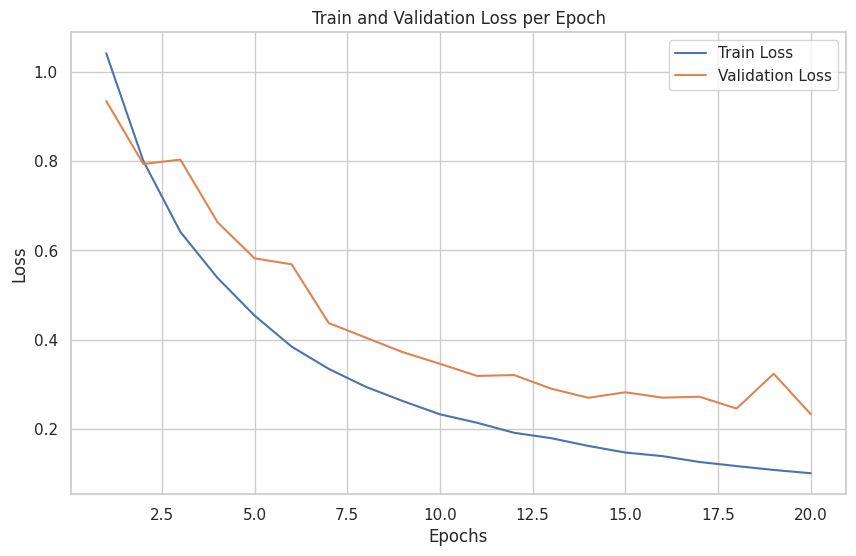

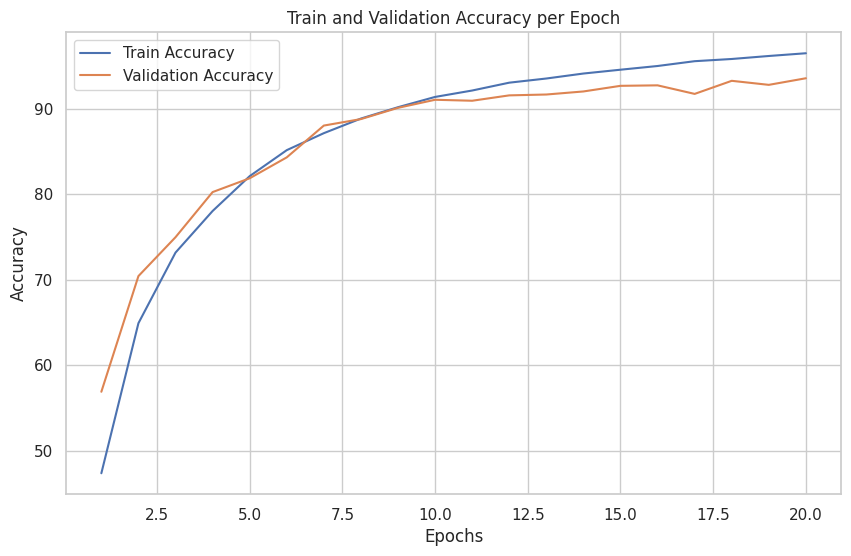

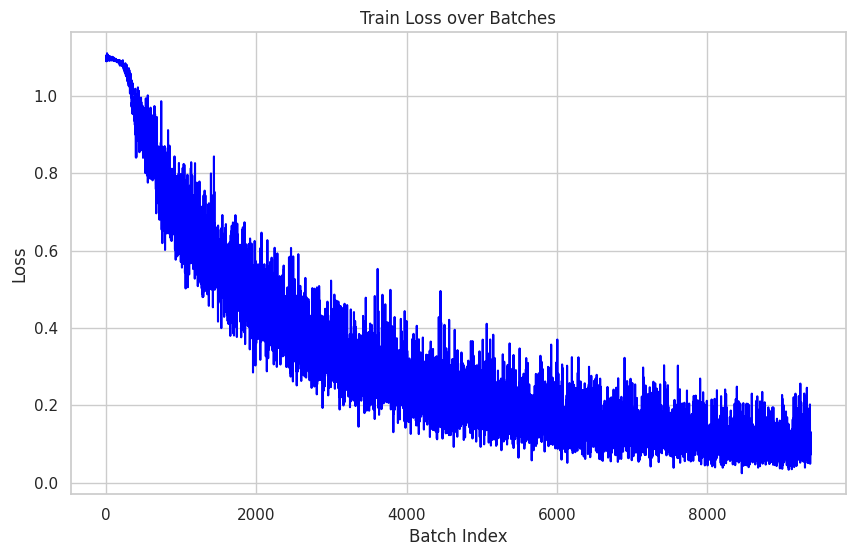

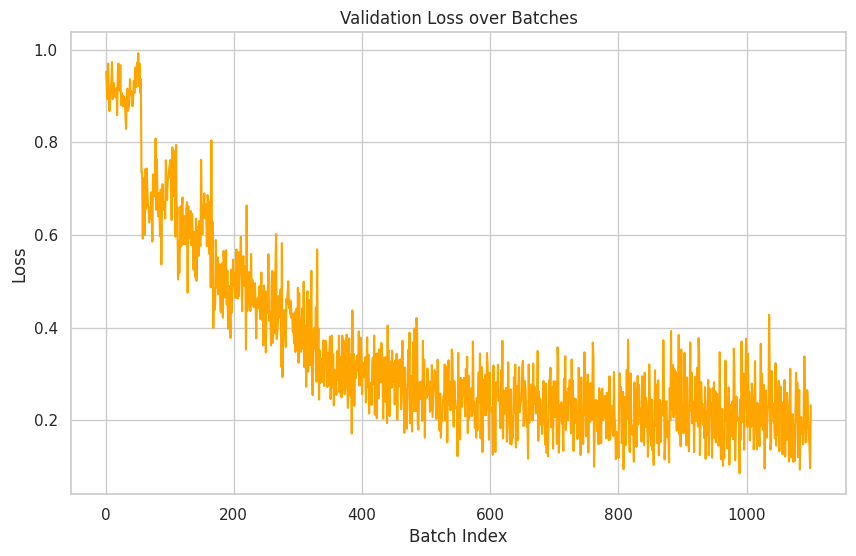

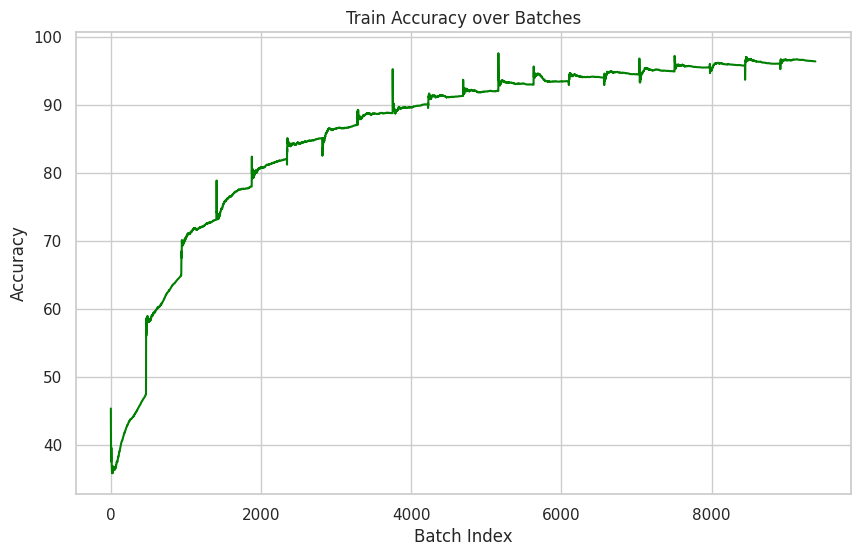

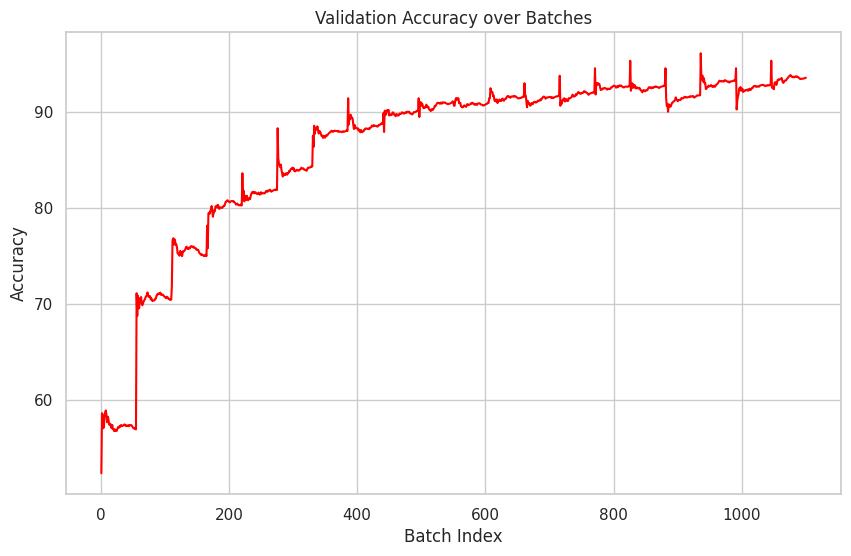

In [44]:
import matplotlib.pyplot as plt

def plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies, 
                          total_train_loss, total_val_loss, total_train_acc, total_val_acc):
    epochs = range(1, len(train_losses) + 1)

    # 1. Unico grafico con train e val loss per ogni epoca
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2. Unico grafico con train e val accuracy per ogni epoca
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train and Validation Accuracy per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 3. Grafico con solo train loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(total_train_loss) + 1), total_train_loss, label='Train Loss', color='blue')
    plt.xlabel('Batch Index')
    plt.ylabel('Loss')
    plt.title('Train Loss over Batches')
    plt.grid(True)
    plt.show()

    # 4. Grafico con solo val loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(total_val_loss) + 1), total_val_loss, label='Validation Loss', color='orange')
    plt.xlabel('Batch Index')
    plt.ylabel('Loss')
    plt.title('Validation Loss over Batches')
    plt.grid(True)
    plt.show()

    # 5. Grafico con solo train accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(total_train_acc) + 1), total_train_acc, label='Train Accuracy', color='green')
    plt.xlabel('Batch Index')
    plt.ylabel('Accuracy')
    plt.title('Train Accuracy over Batches')
    plt.grid(True)
    plt.show()

    # 6. Grafico con solo val accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(total_val_acc) + 1), total_val_acc, label='Validation Accuracy', color='red')
    plt.xlabel('Batch Index')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy over Batches')
    plt.grid(True)
    plt.show()

plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies,
                        total_train_loss, total_val_loss, total_train_acc, total_val_acc)

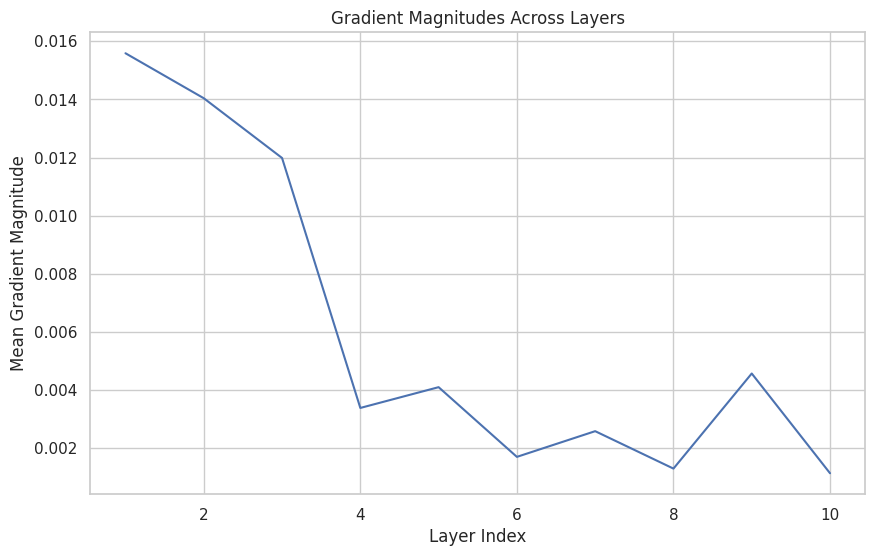

In [45]:
def plot_gradient(model):
    gradients = []
    for param in model.parameters():
        if param.grad is not None:
            gradients.append(param.grad.abs().mean().item())
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(gradients) + 1), gradients)
    plt.xlabel('Layer Index')
    plt.ylabel('Mean Gradient Magnitude')
    plt.title('Gradient Magnitudes Across Layers')
    plt.grid(True)
    plt.show()

plot_gradient(model)

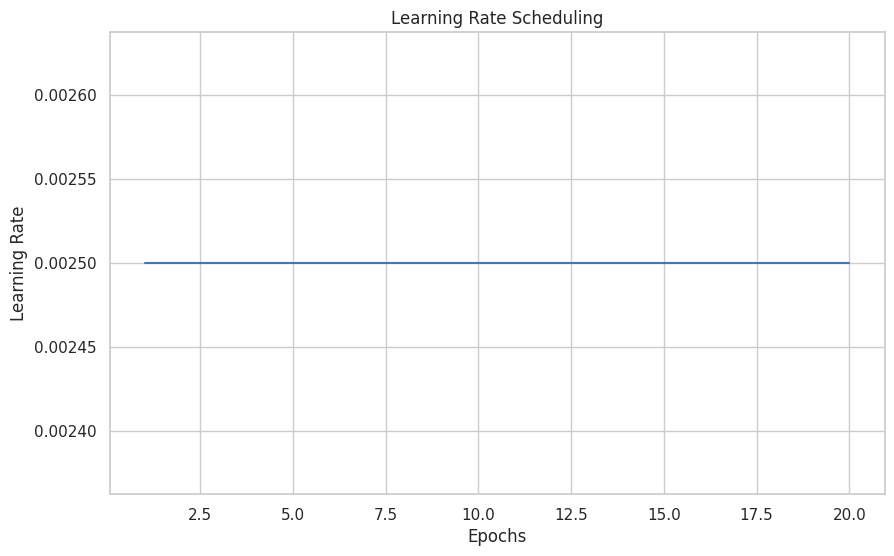

In [46]:
def plot_lr_scheduler(lr_history):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(lr_history) + 1), lr_history)
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Scheduling')
    plt.grid(True)
    plt.show()

plot_lr_scheduler(lr_history)

452 previsioni errate trovate.


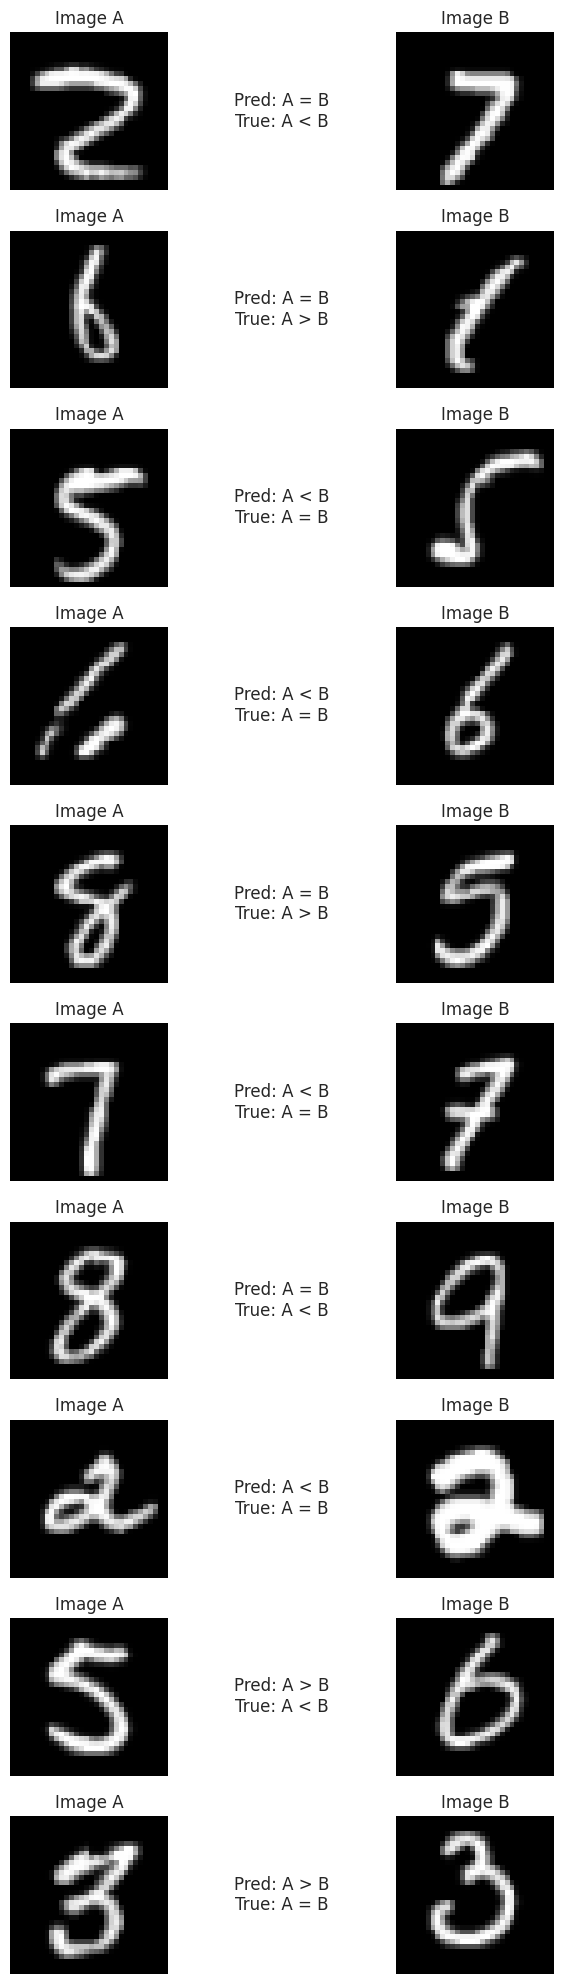

In [47]:
def show_incorrect_predictions(model, dataloader, num_images=5):
    model.eval()
    all_images = []
    all_labels = []
    all_preds = []

    # Itera su tutti i batch nel dataloader
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images.to(device))
            _, predicted = torch.max(outputs, 1)
            
            all_images.append(images.cpu())
            all_labels.append(labels.cpu())
            all_preds.append(predicted.cpu())

    # Concatena tutti i batch raccolti
    all_images = torch.cat(all_images)
    all_labels = torch.cat(all_labels)
    all_preds = torch.cat(all_preds)

    # Trova gli indici delle previsioni errate
    incorrect_predictions = (all_preds != all_labels).nonzero(as_tuple=True)[0]

    print(f"{len(incorrect_predictions)} previsioni errate trovate.")

    if len(incorrect_predictions) == 0:
        print("Nessuna previsione errata trovata.")
        return

    # Limita il numero di immagini errate da mostrare
    num_images = min(num_images, len(incorrect_predictions))

    fig, axes = plt.subplots(num_images, 3, figsize=(6, num_images * 2))
    relation_labels = {0: 'A > B', 1: 'A < B', 2: 'A = B'}
    
    for idx, i in enumerate(incorrect_predictions[:num_images]):
        img_A = all_images[i][0, :, :]
        img_B = all_images[i][1, :, :]
        pred_label = all_preds[i].item()
        true_label = all_labels[i].item()

        # Mostra l'immagine A
        axes[idx, 0].imshow(img_A, cmap='gray')
        axes[idx, 0].set_title('Image A')
        axes[idx, 0].axis('off')

        # Mostra l'etichetta di relazione prevista e reale
        axes[idx, 1].text(0.5, 0.5, f'Pred: {relation_labels[pred_label]}\nTrue: {relation_labels[true_label]}', 
                          fontsize=12, ha='center', va='center')
        axes[idx, 1].axis('off')

        # Mostra l'immagine B
        axes[idx, 2].imshow(img_B, cmap='gray')
        axes[idx, 2].set_title('Image B')
        axes[idx, 2].axis('off')

    plt.tight_layout()
    plt.show()
    return fig

# Visualizza alcune previsioni errate
writer.add_figure('Incorrect_predictions', show_incorrect_predictions(model, validation_loader, num_images=10))
#show_incorrect_predictions(model, validation_loader, num_images=5)


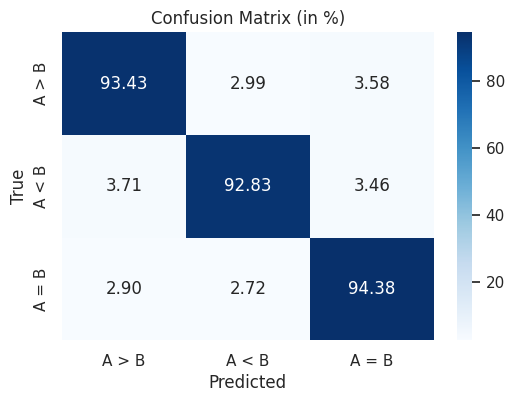

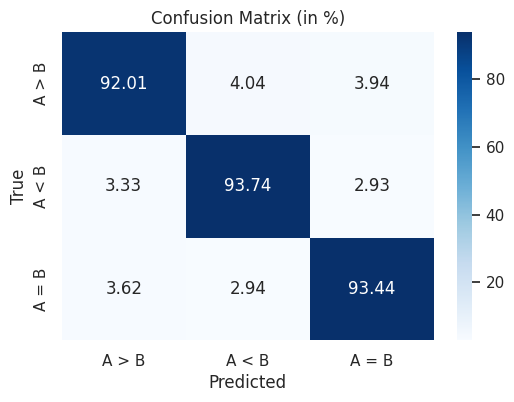

In [48]:
# Funzione per calcolare e stampare la matrice di confusione normalizzata
def plot_confusion_matrix(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    # Disabilita i gradienti per velocizzare il calcolo
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Crea la matrice di confusione
    cm = confusion_matrix(all_labels, all_preds)
    
    # Normalizza la matrice di confusione
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalizza per ogni riga (classe vera)
    
    # Visualizza la matrice di confusione normalizzata in percentuale
    fig = plt.figure(figsize=(6, 4))
    sns.heatmap(cm_normalized * 100, annot=True, fmt=".2f", cmap="Blues", 
                xticklabels=['A > B', 'A < B', 'A = B'], 
                yticklabels=['A > B', 'A < B', 'A = B'])
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (in %)')
    plt.show()

    return fig

# Calcola e visualizza la matrice di confusione
writer.add_figure('Confusion_matrix_validation', plot_confusion_matrix(model, validation_loader, device))
writer.add_figure('Confusion_matrix_test', plot_confusion_matrix(model, test_loader, device))
#plot_confusion_matrix(model, test_loader, device)


In [49]:
def classification_metrics(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    # Disabilita i gradienti per velocizzare il calcolo
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Genera il report di classificazione
    report = classification_report(all_labels, all_preds, target_names=['A > B', 'A < B', 'A = B'])
    print(report)

# Stampa il report delle metriche
classification_metrics(model, test_loader, device)


              precision    recall  f1-score   support

       A > B       0.93      0.92      0.92       989
       A < B       0.93      0.94      0.93       990
       A = B       0.93      0.93      0.93      1021

    accuracy                           0.93      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.93      0.93      0.93      3000



Precision: Il numero di veri positivi diviso per il numero di esempi che sono stati predetti come positivi.
Recall (Sensibilità): Il numero di veri positivi diviso per il numero di esempi che appartengono effettivamente alla classe positiva.
F1-Score: La media armonica tra precisione e recall. È utile quando hai un dataset squilibrato.
Support: Il numero di campioni effettivi per ogni classe.

In [50]:
def save_notebook_copy(notebook_name='main.ipynb'):
    # Leggi il notebook attuale
    with open(notebook_name, 'r') as f:
        notebook_content = nbformat.read(f, as_version=4)
    
    # Costruisci il nome base del nuovo notebook
    if OPTIMIZER == 'SGD':
        base_name = f"run32x32_BS={BATCH_SIZE}_LR={LEARNING_RATE}_MOM={MOMENTUM}_EPOCHS={EPOCHS}_AUG={AUGMENT_DATASET}_TRA={TRANSFORM_DATASET}_OPT={OPTIMIZER}"
    elif OPTIMIZER == 'ADAM':
        base_name = f"run32x32_BS={BATCH_SIZE}_LR={LEARNING_RATE}_EPOCHS={EPOCHS}_AUG={AUGMENT_DATASET}_TRA={TRANSFORM_DATASET}_OPT={OPTIMIZER}"
    else:
        base_name = "run32x32"

    # Aggiungi estensione .ipynb
    new_notebook_name = f"{base_name}.ipynb"

    # Evita sovrascritture aggiungendo un numero incrementale se il file esiste
    counter = 1
    while os.path.exists(new_notebook_name):
        new_notebook_name = f"{base_name}_{counter}.ipynb"
        counter += 1

    # Salva il notebook con il nuovo nome
    with open(new_notebook_name, 'w') as f:
        nbformat.write(notebook_content, f)
    
    print(f"Notebook saved as {new_notebook_name}")


# Specifica il nome del notebook attuale
save_notebook_copy('main_32x32.ipynb')


Notebook saved as run32x32_BS=128_LR=0.0025_MOM=0.9_EPOCHS=20_AUG=False_TRA=False_OPT=SGD.ipynb


In [51]:
writer.close()